In [ ]:
# -*- coding: utf-8 -*-
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#

# Model-based Collaborative Filtering - Movie Recommender
In this Jupyter notebook, we dive into **Model-based Collaborative Filtering**, an advanced recommendation system technique that utilizes **Matrix Factorization** to learn latent factors from user-item interactions using **Embedding layers**. The model is trained to predict the ratings a user might give to unseen items, and then employs these predictions along with clustering technique **Kmeans** to discover and suggest personalized recommendations based on patterns of user preferences and item similarities.

## Dataset
Download  **[ml-latest-small.zip (size: 1 MB)](https://grouplens.org/datasets/movielens/latest/)** and decompress it into **data** folder. This zip file contains 4 csv files, but we will work only with 
- **movies.csv**
- **ratings.csv**.

Since we work with collaborative filtering we need only **ratings.csv** for finding recommendetions, but **movies.csv** contains **name** of movie that will be displayed in final recommendations for a user. **ratings.csv** file contains following features:
- __userId__ - id of user
- __movieId__ - id of movie
- __rating__ - rating in scale from 1 - 5 (0.5, 1.5, 2.5, 3.5, 4.5 - also included)
- __timestamp__ - unix timestamp of rating

**movies.csv** contains following features:
- __movieId__ - id of movie
- __title__ - movie's title
- __genres__ - movie's genres

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [ ]:
movies_df = pd.read_csv('data/movies.csv')
ratings_df = pd.read_csv('data/ratings.csv')

In [ ]:
movies_df.head()

In [ ]:
ratings_df.head(10)

In [ ]:
movies_df.movieId.sort_values()

In [ ]:
movies_df.shape

In [ ]:
ratings_df.shape

In [ ]:
n_users = len(ratings_df.userId.unique())
n_items = len(ratings_df.movieId.unique())

In [ ]:
print("Number of unique users:", n_users)
print("Number of unique movies:", n_items)
print("The full rating matrix will have:", n_users*n_items, 'elements.')
print('----------')
print("Number of ratings:", len(ratings_df))
print("Therefore: ", len(ratings_df) / (n_users*n_items) * 100, '% of the matrix is filled.')


We have an incredibly sparse matrix to work with here.
And... as you can imagine, as the number of users and products grow, the number of elements will increase by n*2
You are going to need a lot of memory to work with global scale... storing a full matrix in memory would be a challenge.
One advantage here is that matrix factorization can realize the rating matrix implicitly, thus we don't need all the data.

## What is Matrix Factorization?
### Matrix Factorization for Recommendation Systems

Matrix Factorization is a foundational algorithm in recommendation systems. It works by decomposing the user-item interaction matrix (Ranking Matrix) into two lower dimensionality rectangular matrices (User Matrix and Item Matrix) whose product is the approximation of the original matrix. These two matrices correspond to user and item features, respectively, where each feature captures some characteristics of users and items.

<div>
<center>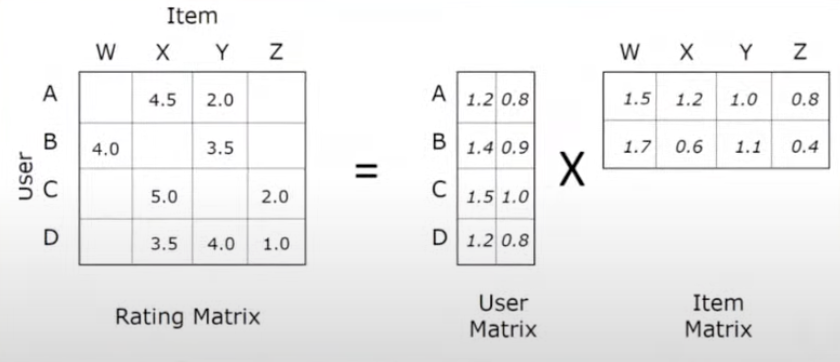</center>
</div>
</br>
</br>
The key idea is that each user and each item is associated with a vector (embedding) in a shared latent space of a fixed dimension (number of factors). The inner product of these vectors represents the interaction between users and items, which can be interpreted as the predicted rating or preference score.

### Embedding Layers

Embedding layers are crucial components of neural network-based recommendation systems, like the one implemented in the notebook. They effectively map categorical variables (like user IDs and item IDs) into continuous vectors within a latent space.

- **User Embeddings**: Each user ID is mapped to a vector that captures the user's preferences and characteristics.
- **Item Embeddings**: Similarly, each item ID is mapped to a vector that represents the item's features.

These embeddings are learned during the training process and are used to predict the rating or preference a user would give to an item. By training the model, we are essentially learning the 'taste' embedded within user vectors and the 'appeal' embedded within item vectors.

Embeddings also help in capturing the similarity among users and items. Users with similar tastes will be closer in the latent space, as will items that share similar characteristics.

<div>
<center>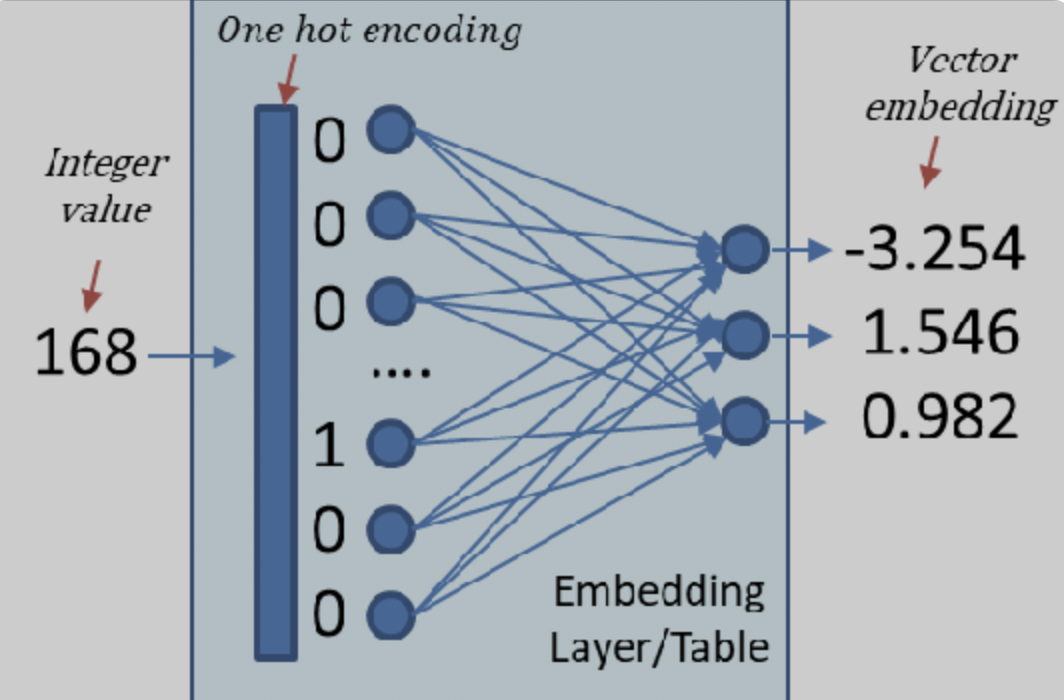</center>
</div>
</br>
</br>

Overall, combining Matrix Factorization and Embedding Layers allows the model to capture complex user-item interactions and make personalized recommendations.

## Our custom Model
This is a custom class that inherits from torch.nn.Module, which is the base class for all neural network modules in PyTorch.
- __init__: The constructor method takes three parameters: **n_users, n_items, and n_factors**. It initializes two types of embeddings – one for users and one for items. Embeddings are basically tables that will learn to map user IDs and item IDs to vectors of **n_factors** dimensions. The embeddings are initially filled with small random values (uniform distribution between 0 and 0.05).
- __user_factors__ and __item_factors__: These are embedding layers created using __torch.nn.Embedding__, which will learn a vector (of n_factors length) for each user and item during the training process. These embeddings capture latent factors of users and items.
- __forward__: The forward method is called when you pass data to the model. It performs the core operation of matrix factorization. The data is expected to be a 2D tensor where each row contains a user-item pair. It extracts the user and item indices and then looks up their respective embeddings. The embeddings are multiplied element-wise (Hadamard product) and then summed along the columns to give the predicted rating for each user-item pair.
- __predict__: A convenience method that internally calls the forward method. This can be used after the model is trained to make predictions on new user-item pairs.

In [ ]:
import torch
import numpy as np
from torch.autograd import Variable
from tqdm import tqdm_notebook as tqdm

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors) 
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors) 

        # initial weights embeddings's weights
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.item_factors.weight.data.uniform_(0, 0.05)
        
    def forward(self, data):
        # matrix multiplication
        users, items = data[:,0], data[:,1]
        return (self.user_factors(users)*self.item_factors(items)).sum(1)
    
    def predict(self, user, item):
        return self.forward(user, item)

## Data Loader class
Inherits from the Dataset class and provides mechanisms to preprocess and serve data to the model in a way that's compatible with PyTorch's expectations. The class has to override following methods:
- __init__: The constructor method takes two parameters, n_users and n_movies. Within this method:
    - A copy of the ratings_df DataFrame is created and stored.
    - Continuous, zero-indexed IDs for users and movies are generated to be used internally by the neural network. Often in datasets, IDs are non-sequential or have gaps, but for a model, it's easier to work with contiguous ranges of integers.
    - The **userid2idx** and **movieid2idx** dictionaries map the original user and movie IDs to the new, continuous indices.
    - The **idx2userid** and **idx2movieid** dictionaries provide the reverse mapping.
    - The original user and movie IDs in ratings_df are replaced with the new continuous IDs.
    - The feature matrix x (user and movie IDs) and the target vector y (ratings) are extracted from ratings_df, with the non-feature columns dropped.
    - **x** and **y** are converted to PyTorch tensors, as PyTorch models work with tensors.
- __getitem__: This method is required by the PyTorch Dataset class. It allows the DataLoader to retrieve a single sample (a pair of feature and target tensors) by index.
- __len__: Also required by the PyTorch Dataset class, it returns the total number of samples in the dataset.

In [ ]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader # package that helps transform your data to machine learning readiness

# Note: This isn't 'good' practice, in a MLops sense but we'll roll with this since the data is already loaded in memory.
class Loader(Dataset):
    def __init__(self, users, movies):
        self.ratings = ratings_df.copy()
        
        #--- Producing new continuous IDs for users and movies ---
        
        # Unique values : index
        self.userid2idx = {o:i for i,o in enumerate(users)}
        self.movieid2idx = {o:i for i,o in enumerate(movies)}
        
        # Obtained continuous ID for users and movies
        self.idx2userid = {i:o for o,i in self.userid2idx.items()}
        self.idx2movieid = {i:o for o,i in self.movieid2idx.items()}
        
        # return the id from the indexed values as noted in the lambda function down below.
        self.ratings.movieId = ratings_df.movieId.apply(lambda x: self.movieid2idx[x])
        self.ratings.userId = ratings_df.userId.apply(lambda x: self.userid2idx[x])
        
        
        self.x = self.ratings.drop(['rating', 'timestamp'], axis=1).values
        self.y = self.ratings['rating'].values
        self.x, self.y = torch.tensor(self.x), torch.tensor(self.y) # Transforms the data to tensors (ready for torch models.)

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.ratings)

## Model Training Setup

We initialize our training with the following parameters and components:

- **Epochs**: The training process is set to run for 128 epochs. An epoch is a full pass through the entire dataset.

- **Model Instantiation**: A `MatrixFactorization` model is created with the number of unique users and movies as parameters, allowing the model to create appropriate embeddings for each.

- **Model Overview**: We print the model's structure to understand its layers and parameters. This also includes a check for all the parameters that require gradient computations, indicating they will be updated during the training process.

- **Loss Function**: The Mean Squared Error Loss (MSELoss) is chosen as the loss function. It computes the average of the squares of the differences between the predicted and actual ratings, which is appropriate for a regression problem like ours.

- **Optimizer**: The ADAM optimizer, known for its efficiency in handling sparse gradients and adaptive learning rate capabilities, is used to minimize the loss function. We set the learning rate to `1e-3`.

- **Data Preparation**: 
  - We extract all unique user and movie IDs from the ratings dataframe to ensure our `Loader` class creates a comprehensive index for all entities.
  - A custom `Loader` class, compatible with PyTorch's `DataLoader`, is used to prepare our training data, allowing for easy batch processing and shuffling.

- **DataLoader**: Finally, we instantiate a `DataLoader` with the training set, which abstracts away the complexity of handling the iterative training process. It loads the data in batches of 128 and shuffles it to introduce randomness, which helps improve the generalization of the model.

With all the components in place, we're ready to begin training our model to predict user ratings for movies accurately.


In [ ]:
num_epochs = 128
model = MatrixFactorization(n_users, n_items)
print(model)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

loss_fn = torch.nn.MSELoss()

# ADAM optimizier
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train data
users = ratings_df.userId.unique()
movies = ratings_df.movieId.unique()

train_set = Loader(users, movies)
train_loader = DataLoader(train_set, 128, shuffle=True)

## Training Loop

The model is trained over the specified number of epochs. During each epoch, the following steps are performed:

- **Batch Processing**: For each batch in our `DataLoader`:
  - **Gradient Reset**: The gradients are reset by calling `optimizer.zero_grad()` to ensure that we start with a clean slate for each training iteration.
  - **Model Output**: The `model` is applied to the input data `x` to generate predictions, denoted as `outputs`.
  - **Loss Calculation**: The `loss_fn` computes the loss by comparing the `outputs` from the model with the true `y` values. Since `loss_fn` requires both arguments to be of the same type, we ensure `y` is a `torch.float32`.
  - **Loss Recording**: The computed loss for the current batch is added to the `losses` list to track progress.
  - **Backpropagation**: The `loss.backward()` function is called to compute the gradient of the loss with respect to all weights and biases in the model.
  - **Optimization Step**: The `optimizer.step()` function is invoked to adjust the weights and biases to minimize the loss.

- **Epoch Loss Reporting**: At the end of each epoch, the average loss is calculated and printed. This gives us insight into how the model's performance is improving over time.

The use of `tqdm` provides a progress bar for each epoch, offering a visual cue on the training progress.

This loop is critical for the iterative improvement of our model, as it learns to make better predictions with each pass over the training dataset.


In [ ]:
# !pip install tqdm
# !pip install jupyter
# !pip install ipywidgets widgetsnbextension pandas-profiling

In [ ]:
for it in tqdm(range(num_epochs)):
    losses = []
    for x, y in train_loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs.squeeze(), y.type(torch.float32))
        losses.append(loss.item())
        loss.backward()
        optimizer.step()
    print("iter #{}".format(it), "Loss:", sum(losses) / len(losses))

## Ranking

In this code, we are integrating a trained `MatrixFactorization` model with `KMeans` clustering to generate movie recommendations. Here is an explanation of the code flow:

1. **Extracting User Embeddings**: We start by extracting user embeddings from the pre-trained `MatrixFactorization` model. These embeddings are vectors representing users' preferences in a latent space.

2. **Clustering with KMeans**: The `KMeans` algorithm is then applied to these user embeddings to segment the users into clusters. Each cluster groups users with similar preference patterns. We set the number of clusters to 10 and fix the random state for reproducibility.

3. **Mapping Users to Clusters**: We create a dictionary mapping each user to their respective cluster label determined by `KMeans`.

4. **Recommendation Function**: The function `recommend_items_for_cluster` is defined to recommend items for users within a specific cluster. The steps are as follows:
   
   - It identifies all the users belonging to the requested cluster.
   - Filters the ratings dataframe to include only ratings from these users.
   - Computes the average rating for each movie within the cluster.
   - Excludes movies that the target user has already rated.
   - Sorts the remaining movies by their average rating and selects the top N.
   - Converts the movie indices back to their original movie IDs if a mapping (`movieid2idx`) is provided.

5. **Generating Recommendations**: Lastly, we demonstrate how to use the `recommend_items_for_cluster` function to generate recommendations for a specific user. We determine the user's cluster, invoke the recommendation function, and obtain the top N recommended movie IDs.


**Running note:** Torch is not running in Apple M1/M2 hardware architecture

In [ ]:
from sklearn.cluster import KMeans

user_factors = model.user_factors.weight.data.numpy() 

kmeans = KMeans(n_clusters=10, random_state=42)
user_labels = kmeans.fit_predict(user_factors)

user_cluster_map = {i: cluster for i, cluster in enumerate(user_labels)}


def recommend_items_for_cluster(cluster_id, user_id, user_cluster_map, ratings_df, movieid2idx, idx2movieid, N=5):
    users_in_cluster = [uid for uid, cluster in user_cluster_map.items() if cluster == cluster_id]
    print(users_in_cluster)

    cluster_ratings = ratings_df[ratings_df['userId'].isin(users_in_cluster)]

    average_ratings = cluster_ratings.groupby('movieId')['rating'].mean().sort_values(ascending=False)
    
    user_rated_movies = set(ratings_df[ratings_df['userId'] == user_id]['movieId'])
    
    recommendations = average_ratings[~average_ratings.index.isin(user_rated_movies)]

    top_n_recommendations = recommendations.head(N).index.tolist()
    
    original_movie_ids = [idx2movieid[idx] for idx in top_n_recommendations if idx in idx2movieid]
    
    return original_movie_ids

user_id = 6

user_cluster = user_cluster_map[user_id]  

recommendations = recommend_items_for_cluster(user_cluster, user_id, user_cluster_map, train_set.ratings, train_set.movieid2idx, train_set.idx2movieid)
recommendations

In [ ]:
movie_titles = dict(zip(movies_df.movieId, movies_df.title))

recommended_titles = [movie_titles[movie_id] for movie_id in recommendations if movie_id in movie_titles]

for title in recommended_titles:
    print(title)